Central referrence image is 4


RANSAC Progress:   0%|                                                   | 0/1000 [00:00<?, ?iter/s]


Final Results:
Total time: 0.51s
Best inlier ratio: 79.8%
Final error: 2.02


RANSAC Progress:   0%|                                                   | 0/1000 [00:00<?, ?iter/s]


Final Results:
Total time: 0.49s
Best inlier ratio: 63.7%
Final error: 1.08


RANSAC Progress:   0%|                                                   | 0/1000 [00:00<?, ?iter/s]


Final Results:
Total time: 0.78s
Best inlier ratio: 64.8%
Final error: 1.74


RANSAC Progress:   0%|                                                   | 0/1000 [00:00<?, ?iter/s]


Final Results:
Total time: 0.44s
Best inlier ratio: 95.6%
Final error: 0.89


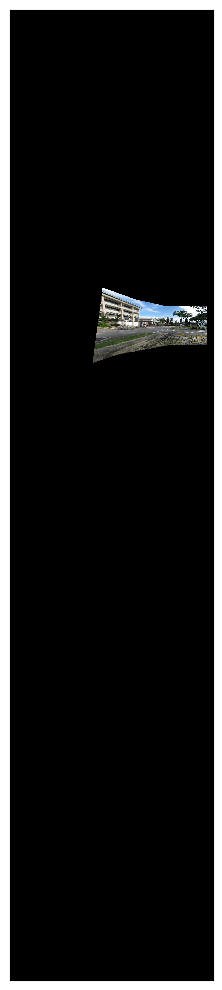

In [2]:
import os
import glob
import numpy as np
import cv2
import time
from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt


def warp_perspective(src_img, homography_matrix, output_size):
    """
    Custom implementation of perspective warping using bilinear interpolation
    Handles both RGB (3-channel) and grayscale (1-channel) images
    
    Parameters:
    src_img (numpy.ndarray): Source image to warp (2D or 3D array)
    homography_matrix (numpy.ndarray): 3x3 homography transformation matrix
    output_size (tuple): Size of the output image (width, height)
    
    Returns:
    numpy.ndarray: Warped image with same number of channels as input
    """
    height, width = output_size[1], output_size[0]
    
    # Determine if input is grayscale or RGB
    is_grayscale = len(src_img.shape) == 2
    num_channels = 1 if is_grayscale else src_img.shape[2]
    
    # Initialize output array with appropriate dimensions
    if is_grayscale:
        dest_img = np.zeros((height, width), dtype=np.float32)
    else:
        dest_img = np.zeros((height, width, num_channels), dtype=np.float32)
    
    # Create meshgrid of coordinates in destination image
    y_coords, x_coords = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    
    # Create homogeneous coordinates
    homogeneous_coords = np.stack([x_coords.ravel(), y_coords.ravel(), np.ones_like(x_coords.ravel())], axis=1)
    
    # Apply inverse homography
    H_inv = np.linalg.inv(homography_matrix)
    src_coords = np.dot(H_inv, homogeneous_coords.T)
    
    # Convert back to inhomogeneous coordinates
    src_coords = src_coords[:2, :] / src_coords[2, :]
    src_x = src_coords[0, :].reshape(height, width)
    src_y = src_coords[1, :].reshape(height, width)
    
    # Find valid source coordinates
    valid_mask = (src_x >= 0) & (src_x < src_img.shape[1]-1) & \
                (src_y >= 0) & (src_y < src_img.shape[0]-1)
    
    # Get integer and fractional parts for bilinear interpolation
    src_x_0 = np.floor(src_x[valid_mask]).astype(int)
    src_x_1 = src_x_0 + 1
    src_y_0 = np.floor(src_y[valid_mask]).astype(int)
    src_y_1 = src_y_0 + 1
    
    # Get weights for bilinear interpolation
    x_weight_1 = src_x[valid_mask] - src_x_0
    x_weight_0 = 1 - x_weight_1
    y_weight_1 = src_y[valid_mask] - src_y_0
    y_weight_0 = 1 - y_weight_1
    
    if is_grayscale:
        # Perform bilinear interpolation for grayscale
        pixel_values = src_img[src_y_0, src_x_0] * x_weight_0 * y_weight_0 + \
                      src_img[src_y_0, src_x_1] * x_weight_1 * y_weight_0 + \
                      src_img[src_y_1, src_x_0] * x_weight_0 * y_weight_1 + \
                      src_img[src_y_1, src_x_1] * x_weight_1 * y_weight_1
        dest_img[valid_mask] = pixel_values
    else:
        # Perform bilinear interpolation for each channel
        for channel in range(num_channels):
            pixel_values = src_img[src_y_0, src_x_0, channel] * x_weight_0 * y_weight_0 + \
                          src_img[src_y_0, src_x_1, channel] * x_weight_1 * y_weight_0 + \
                          src_img[src_y_1, src_x_0, channel] * x_weight_0 * y_weight_1 + \
                          src_img[src_y_1, src_x_1, channel] * x_weight_1 * y_weight_1
            dest_img[valid_mask, channel] = pixel_values
    
    return dest_img.astype(src_img.dtype)




class PanaromaStitcher():
    def __init__(self):
        self.pano_image_final = None
        self.Homography_matrix_final = None
    

    def make_panaroma_for_images_in(self, path, central_img = 3):
        # Compute homography matrices between consecutive image pairs
        

        last_folder = os.path.basename(path)
    
        if last_folder.startswith("I") and last_folder[1:].isdigit():
            folder_number = int(last_folder[1:])
            if folder_number in [1]:
                central_img = 2
            elif folder_number in [3, 4, 5, 6]:
                central_img = 3
            elif folder_number in [2]:
                central_img = 4

        print(f"Central referrence image is {central_img}")
        transformation_matrices = []
        num_images = len(os.listdir(path))
        
        # Calculate transformations between consecutive images
        for image_idx in range(num_images - 1):
            homography = self.estimate_transformation_between_images(
                path,
                image_idx,
                image_idx + 1
            )
            transformation_matrices.append(homography)
        
        # Load all images from directory
        image_paths = sorted(glob.glob(path+os.sep+'*'))
        input_images = [cv2.imread(curr_path) for curr_path in image_paths]
        
        # Stitch images using computed transformations
        self.pano_image_final = self.blend_and_stitch_images_using_homography(
            transformation_matrices, 
            input_images, 
            central_img
        )
        self.Homography_matrix_final = transformation_matrices
        
        return self.pano_image_final, self.Homography_matrix_final
    

    
    
    def generate_weight_map(self, matrix_size: tuple[int]) -> np.ndarray:
        
        row_weights = self.generate_symmetric_weights(matrix_size[0])
        col_weights = self.generate_symmetric_weights(matrix_size[1])
        

        row_weights_reshaped=row_weights.reshape(-1,1)
        col_weights_reshaped=col_weights.reshape(-1,1)

        return row_weights_reshaped @ col_weights_reshaped.T


    def ransac_modelFit_outlier(self, source_points, target_points, distance_threshold=5.0, 
                           min_samples=4, max_iterations=1000):
        
        
        def create_homography_system(src_pts, dst_pts):
            num_points = len(src_pts)
            system_matrix = np.zeros((2 * num_points, 9))
            
            for idx in range(num_points):
                x, y = src_pts[idx]
                u, v = dst_pts[idx]
                system_matrix[2*idx] = [-x, -y, -1, 0, 0, 0, x*u, y*u, u]
                system_matrix[2*idx + 1] = [0, 0, 0, -x, -y, -1, x*v, y*v, v]
                
            return system_matrix
        
        def compute_homography(src_pts, dst_pts):
            A = create_homography_system(src_pts, dst_pts)
            _, _, vh = np.linalg.svd(A)
            H = vh[-1].reshape(3, 3)
            return H
        
        def apply_homography(points, H):
            homogeneous_pts = np.hstack([points, np.ones((len(points), 1))])
            transformed = (H @ homogeneous_pts.T).T
            return transformed[:, :2] / transformed[:, 2:]
        
        optimal_inliers = []
        optimal_matrix = None
        best_error = float('inf')
        start_time = time.time()
        
        
        pbar = tqdm(
            range(max_iterations),
            desc="RANSAC Progress",
            unit="iter",
            bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} "
                    "[{elapsed}<{remaining}, {rate_fmt}{postfix}]",
            colour='cyan',
            ncols=100,
            ascii="░▒█"
        )
        
        for iteration in pbar:
            # Sample random subset of points
            sample_indices = np.random.choice(len(source_points), min_samples, replace=False)
            sample_src = np.array([source_points[i] for i in sample_indices])
            sample_dst = np.array([target_points[i] for i in sample_indices])
            
            # Calculate transformation
            transform = compute_homography(sample_src, sample_dst)
            
            # Transform all points and find inliers
            predicted_points = apply_homography(np.array(source_points), transform)
            errors = np.linalg.norm(predicted_points - np.array(target_points), axis=1)
            current_inliers = np.where(errors < distance_threshold)[0]
            current_error = np.mean(errors[current_inliers]) if len(current_inliers) > 0 else float('inf')
            
            # Update best result if we found more inliers
            if len(current_inliers) > len(optimal_inliers) or (
                len(current_inliers) == len(optimal_inliers) and current_error < best_error
            ):
                optimal_inliers = current_inliers
                optimal_matrix = transform
                best_error = current_error
            
            # Update progress bar with current statistics
            pbar.set_postfix({
                'inliers': f"{len(optimal_inliers)}/{len(source_points)}",
                'error': f"{best_error:.2f}",
                'success_rate': f"{(len(optimal_inliers)/len(source_points))*100:.1f}%"
            })
        
        # Refine homography using all inliers
        if len(optimal_inliers) > min_samples:
            final_src = np.array([source_points[i] for i in optimal_inliers])
            final_dst = np.array([target_points[i] for i in optimal_inliers])
            optimal_matrix = compute_homography(final_src, final_dst)
        
        total_time = time.time() - start_time
        print(f"\nFinal Results:")
        print(f"Total time: {total_time:.2f}s")
        print(f"Best inlier ratio: {(len(optimal_inliers)/len(source_points))*100:.1f}%")
        print(f"Final error: {best_error:.2f}")
        
        return optimal_matrix


    def get_sift_keypoints_and_descriptors(self, input_image):
        # Convert to grayscale if image is colored
        if len(input_image.shape) == 3:
            processed_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
        else:
            processed_image = input_image.copy()
        
        # Initialize and apply SIFT detector
        feature_detector = cv2.SIFT_create()
        keypoints, descriptors = feature_detector.detectAndCompute(processed_image, mask=None)
        
        return keypoints, descriptors
    
    def generate_symmetric_weights(self, dimension: int) -> np.ndarray:
        """
        Creates a symmetric gradient array for image blending weights
        Args:
            dimension: Target length of the gradient array
        Returns:
            Symmetric gradient array ranging from 0 to 1
        """
        # Calculate midpoint and adjustment for odd lengths
        center_point = dimension // 2
        offset = dimension % 2
        
        # Generate first half with adjusted scaling
        scale_factor = 1.0 / (center_point + offset)
        first_segment = np.linspace(0, center_point + offset - 1, center_point + offset) * scale_factor
        
        # Generate second half by mirroring
        second_segment = first_segment[::-1]
        if not offset:
            result = np.concatenate([first_segment, second_segment])
        else:
            result = np.concatenate([first_segment, second_segment[1:]])
        
        return result.astype(np.float32)

    def merge_leftward_sequence(self, source_frames, transformation_matrices, anchor_index):
        """
        Combines a sequence of frames to the left of an anchor frame using perspective transformations
        """
        # Initialize with first frame
        result_canvas = source_frames[0].astype(np.uint8).copy()
        shift_matrices = []
        blend_weights = self.generate_weight_map(source_frames[0].shape[:2])
        
        for idx in range(anchor_index):
            # Get current transformation
            current_transform = transformation_matrices[idx]
            current_transform = current_transform / current_transform[2, 2]
            
            # Calculate boundary points for current canvas
            canvas_bounds = np.array([
                [0, 0, 1],
                [0, result_canvas.shape[0], 1],
                [result_canvas.shape[1], result_canvas.shape[0], 1],
                [result_canvas.shape[1], 0, 1]
            ])
            
            # Apply transformations
            if idx == 0:
                transformed_bounds = np.dot(current_transform, canvas_bounds.T).T
            else:
                chain_transform = current_transform @ np.linalg.inv(shift_matrices[-1])
                transformed_bounds = np.dot(chain_transform, canvas_bounds.T).T
                
            # Normalize coordinates
            transformed_bounds = transformed_bounds / transformed_bounds[:, 2].reshape(-1, 1)
            
            # Calculate next frame boundaries
            next_frame_bounds = np.array([
                [0, 0, 1],
                [0, source_frames[idx + 1].shape[0], 1],
                [source_frames[idx + 1].shape[1], source_frames[idx + 1].shape[0], 1],
                [source_frames[idx + 1].shape[1], 0, 1]
            ])
            
            # Calculate output dimensions
            combined_bounds = np.concatenate([next_frame_bounds[:, :2], transformed_bounds[:, :2]], axis=0)
            x_min, x_max = int(combined_bounds[:, 0].min()), int(combined_bounds[:, 0].max())
            y_min, y_max = int(combined_bounds[:, 1].min()), int(combined_bounds[:, 1].max())
            
            # Create shift matrix
            shift_transform = np.array([
                [1, 0, -x_min],
                [0, 1, -y_min],
                [0, 0, 1]
            ], dtype=np.float32)
            shift_matrices.append(shift_transform.copy())
            
            # Apply warping transformations
            if idx == 0:
                canvas_warped = warp_perspective(
                    result_canvas,
                    shift_matrices[-1] @ current_transform,
                    (x_max - x_min, y_max - y_min)
                )
            else:
                canvas_warped = warp_perspective(
                    result_canvas,
                    shift_matrices[-1] @ current_transform @ np.linalg.inv(shift_matrices[-2]),
                    (x_max - x_min, y_max - y_min)
                )
            
            next_frame_warped = warp_perspective(
                source_frames[idx + 1],
                shift_matrices[-1],
                (x_max - x_min, y_max - y_min)
            )
            
            # Generate and apply blending masks
            weight_map1 = self.generate_weight_map(source_frames[idx].shape[:2])
            weight_map2 = self.generate_weight_map(source_frames[idx + 1].shape[:2])
            
            if idx == 0:
                canvas_mask = warp_perspective(
                    weight_map1,
                    shift_matrices[-1] @ current_transform,
                    (x_max - x_min, y_max - y_min)
                )
            else:
                canvas_mask = warp_perspective(
                    blend_weights,
                    shift_matrices[-1] @ current_transform @ np.linalg.inv(shift_matrices[-2]),
                    (x_max - x_min, y_max - y_min)
                )
                
            next_frame_mask = warp_perspective(
                weight_map2,
                shift_matrices[-1],
                (x_max - x_min, y_max - y_min)
            )
            
            # Normalize masks
            canvas_mask = (canvas_mask / canvas_mask.max()).astype(np.float32)
            next_frame_mask = (next_frame_mask / next_frame_mask.max()).astype(np.float32)
            
            # Calculate blending weights
            blend_ratio = np.divide(
                canvas_mask,
                canvas_mask + next_frame_mask,
                where=(canvas_mask + next_frame_mask) != 0
            )
            blend_ratio = blend_ratio / blend_ratio.max()
            blend_ratio = np.stack([blend_ratio] * 3, axis=2)
            
            # Update blend weights for next iteration
            blend_weights = (canvas_mask + next_frame_mask) / (canvas_mask + next_frame_mask).max()
            
            # Combine images
            result_canvas = (blend_ratio * canvas_warped + (1 - blend_ratio) * next_frame_warped).astype(np.uint8)
            
        return result_canvas, shift_matrices, blend_weights
    def merge_rightward_sequence(self, input_sequence, perspective_mappings, base_frame_pos):
        """
        Merges a sequence of images rightward from a base frame using perspective transformations
        """
        # Initialize with last frame
        output_composite = input_sequence[-1].astype(np.uint8).copy()
        displacement_transforms = []
        blend_map = self.generate_weight_map(input_sequence[-1].shape[:2])
        
        # Process frames from right to left
        for current_idx in range(len(perspective_mappings) - 1, base_frame_pos, -1):
            # Calculate inverse transformation
            inverse_transform = np.linalg.inv(perspective_mappings[current_idx])
            inverse_transform = inverse_transform / inverse_transform[2, 2]
            
            # Define current frame boundaries
            composite_bounds = np.array([
                [0, 0, 1],
                [0, output_composite.shape[0], 1],
                [output_composite.shape[1], output_composite.shape[0], 1],
                [output_composite.shape[1], 0, 1]
            ])
            
            # Apply sequential transformations
            is_first_frame = current_idx == len(perspective_mappings) - 1
            if is_first_frame:
                projected_bounds = np.dot(inverse_transform, composite_bounds.T).T
            else:
                cumulative_transform = inverse_transform @ np.linalg.inv(displacement_transforms[-1])
                projected_bounds = np.dot(cumulative_transform, composite_bounds.T).T
                
            # Normalize coordinates
            projected_bounds = projected_bounds / projected_bounds[:, 2].reshape(-1, 1)
            
            # Calculate target frame boundaries
            target_bounds = np.array([
                [0, 0, 1],
                [0, input_sequence[current_idx].shape[0], 1],
                [input_sequence[current_idx].shape[1], input_sequence[current_idx].shape[0], 1],
                [input_sequence[current_idx].shape[1], 0, 1]
            ])
            
            # Calculate output dimensions
            merged_bounds = np.concatenate([target_bounds[:, :2], projected_bounds[:, :2]], axis=0)
            x_bounds = int(merged_bounds[:, 0].min()), int(merged_bounds[:, 0].max())
            y_bounds = int(merged_bounds[:, 1].min()), int(merged_bounds[:, 1].max())
            
            # Create displacement matrix
            displacement = np.array([
                [1, 0, -x_bounds[0]],
                [0, 1, -y_bounds[0]],
                [0, 0, 1]
            ], dtype=np.float32)
            displacement_transforms.append(displacement.copy())
            
            # Apply perspective transformations
            output_dims = (x_bounds[1] - x_bounds[0], y_bounds[1] - y_bounds[0])
            if is_first_frame:
                warped_composite = warp_perspective(
                    output_composite,
                    displacement_transforms[-1] @ inverse_transform,
                    output_dims
                )
            else:
                warped_composite = warp_perspective(
                    output_composite,
                    displacement_transforms[-1] @ inverse_transform @ np.linalg.inv(displacement_transforms[-2]),
                    output_dims
                )
            
            warped_target = warp_perspective(
                input_sequence[current_idx],
                displacement_transforms[-1],
                output_dims
            )
            
            # Generate blending masks
            weight_map1 = self.generate_weight_map(input_sequence[current_idx + 1].shape[:2])
            weight_map2 = self.generate_weight_map(input_sequence[current_idx].shape[:2])
            
            if is_first_frame:
                composite_mask = warp_perspective(
                    weight_map1,
                    displacement_transforms[-1] @ inverse_transform,
                    output_dims
                )
            else:
                composite_mask = warp_perspective(
                    blend_map,
                    displacement_transforms[-1] @ inverse_transform @ np.linalg.inv(displacement_transforms[-2]),
                    output_dims
                )
                
            target_mask = warp_perspective(
                weight_map2,
                displacement_transforms[-1],
                output_dims
            )
            
            # Process blending weights
            composite_mask = (composite_mask / np.maximum(composite_mask.max(), 1e-6)).astype(np.float32)
            target_mask = (target_mask / np.maximum(target_mask.max(), 1e-6)).astype(np.float32)
            
            # Calculate blending ratios
            blend_ratios = np.divide(
                composite_mask,
                composite_mask + target_mask,
                where=(composite_mask + target_mask) != 0
            )
            blend_ratios = blend_ratios / np.maximum(blend_ratios.max(), 1e-6)
            blend_ratios = np.stack([blend_ratios] * 3, axis=2)
            
            # Update blending weights for next iteration
            blend_map = (composite_mask + target_mask) / np.maximum((composite_mask + target_mask).max(), 1e-6)
            
            # Merge images
            output_composite = (blend_ratios * warped_composite + 
                            (1 - blend_ratios) * warped_target).astype(np.uint8)
            
        return output_composite, displacement_transforms, blend_map
    
    def estimate_transformation_between_images(self, image_directory: str, source_index: int, 
                                        target_index: int) -> np.ndarray:
        # Gather all images from directory
        image_paths = sorted(glob.glob(os.path.join(image_directory, '*')))
        
        
        # Extract SIFT features for all images
        def load_and_process_image(image_path):
            return self.get_sift_keypoints_and_descriptors(cv2.imread(image_path))
        
        processed_images = [load_and_process_image(path) for path in image_paths]
        
        
        # Match features between specified image pair
        source_keypoints, source_descriptors = processed_images[source_index]
        target_keypoints, target_descriptors = processed_images[target_index]
        
        # Initialize feature matcher and find matches
        feature_matcher = cv2.BFMatcher()
        raw_matches = feature_matcher.knnMatch(source_descriptors, target_descriptors, k=2)
        
        # Apply Lowe's ratio test for match filtering
        RATIO_THRESHOLD = 0.75
        filtered_matches = [first_match for first_match, second_match in raw_matches 
                        if first_match.distance < RATIO_THRESHOLD * second_match.distance]
        
        # Extract matched keypoint coordinates
        source_points = np.array([source_keypoints[match.queryIdx].pt for match in filtered_matches])
        target_points = np.array([target_keypoints[match.trainIdx].pt for match in filtered_matches])
        
        
        # Estimate homography using ransac_modelFit_outlier
        homography_matrix = self.ransac_modelFit_outlier(source_points, target_points)
        
            
        return homography_matrix
    def blend_and_stitch_images_using_homography(self, Homography_matrix_final, images, reference_image_idx):
        """
        Core function for panorama creation by combining image sequences using an anchor frame
        """
        # Handle edge case when anchor is the rightmost image
        if reference_image_idx == len(Homography_matrix_final):
            panorama_left, _, _ = self.merge_leftward_sequence(images, Homography_matrix_final, reference_image_idx)
            return panorama_left
        
        # Process image sequences on both sides
        sequence_right, transform_matrices_right, weights_right = self.merge_rightward_sequence(
            images, Homography_matrix_final, reference_image_idx)
        sequence_left, transform_matrices_left, weights_left = self.merge_leftward_sequence(
            images, Homography_matrix_final, reference_image_idx)
        
        # Prepare final transformation matrix
        perspective_matrix = np.linalg.inv(Homography_matrix_final[reference_image_idx])
        perspective_matrix = perspective_matrix / perspective_matrix[2, 2]
        
        # Define boundary points for right sequence
        source_boundaries = np.array([
            [0, 0, 1],
            [0, sequence_right.shape[0], 1],
            [sequence_right.shape[1], sequence_right.shape[0], 1],
            [sequence_right.shape[1], 0, 1]
        ])
        
        # Calculate transformed boundaries
        is_rightmost = reference_image_idx == len(Homography_matrix_final) - 1
        if not is_rightmost:
            transformed_points = np.dot(
                perspective_matrix @ np.linalg.inv(transform_matrices_right[-1]),
                source_boundaries.T
            ).T
        else:
            transformed_points = np.dot(perspective_matrix, source_boundaries.T).T
            
        # Normalize coordinates
        transformed_points = transformed_points / transformed_points[:, 2].reshape(-1, 1)
        
        # Define boundary points for left sequence
        target_boundaries = np.array([
            [0, 0, 1],
            [0, sequence_left.shape[0], 1],
            [sequence_left.shape[1], sequence_left.shape[0], 1],
            [sequence_left.shape[1], 0, 1]
        ])
        
        # Apply left sequence transformations
        is_leftmost = reference_image_idx == 0
        if not is_leftmost:
            target_boundaries = np.dot(
                np.linalg.inv(transform_matrices_left[-1]),
                target_boundaries.T
            ).T
            
        # Calculate output dimensions
        combined_points = np.concatenate([target_boundaries[:, :2], transformed_points[:, :2]], axis=0)
        x_range = int(combined_points[:, 0].min()), int(combined_points[:, 0].max())
        y_range = int(combined_points[:, 1].min()), int(combined_points[:, 1].max())

        # Create displacement matrix
        displacement = np.array([
            [1, 0, -x_range[0]],
            [0, 1, -y_range[0]],
            [0, 0, 1]
        ], dtype=np.float32)
        
        # Apply perspective transformations
        output_dims = (x_range[1] - x_range[0], y_range[1] - y_range[0])
        
        if not is_rightmost:
            warped_right = warp_perspective(
                sequence_right,
                displacement @ perspective_matrix @ np.linalg.inv(transform_matrices_right[-2]),
                output_dims
            )
        else:
            warped_right = warp_perspective(
                sequence_right,
                displacement @ perspective_matrix,
                output_dims
            )
            
        if not is_leftmost:
            warped_left = warp_perspective(
                sequence_left,
                displacement @ np.linalg.inv(transform_matrices_left[-1]),
                output_dims
            )
        else:
            warped_left = warp_perspective(sequence_left, displacement, output_dims)
        
        # Generate and apply blending masks
        base_weights = self.generate_weight_map(images[-1].shape[:2])
        
        if not is_rightmost:
            right_blend = warp_perspective(
                weights_right,
                displacement @ perspective_matrix @ np.linalg.inv(transform_matrices_right[-2]),
                output_dims
            )
        else:
            right_blend = warp_perspective(
                base_weights,
                displacement @ perspective_matrix,
                output_dims
            )
            
        if not is_leftmost:
            left_blend = warp_perspective(
                weights_left,
                displacement @ np.linalg.inv(transform_matrices_left[-1]),
                output_dims
            )
        else:
            left_blend = warp_perspective(base_weights, displacement, output_dims)
        
        # Normalize blending masks
        right_blend = (right_blend / np.maximum(right_blend.max(), 1e-6)).astype(np.float32)
        left_blend = (left_blend / np.maximum(left_blend.max(), 1e-6)).astype(np.float32)
        
        # Calculate final blending weights
        blend_weights = np.divide(
            right_blend,
            right_blend + left_blend,
            where=(right_blend + left_blend) != 0
        )
        blend_weights = blend_weights / np.maximum(blend_weights.max(), 1e-6)
        blend_weights = np.stack([blend_weights] * 3, axis=2)

        # Combine images
        panorama = blend_weights * warped_right + (1 - blend_weights) * warped_left
        panorama = panorama.astype(np.uint8)

        # Clean up memory
        del right_blend, left_blend, warped_right, warped_left, blend_weights
        return panorama
    
    def show_stitched_image(self, img, figsize=None, gray=False):
        """
        Displays an image with customizable figure size and color mode
        Args:
            img: Input image array
            figsize: Optional tuple for figure dimensions (width, height)
            gray: Boolean flag for grayscale display mode
        """
        # Configure display window
        display_window = plt.figure(figsize=figsize) if figsize else plt.figure()
        
        # Process and display image based on mode
        display_data = (
            img if gray else 
            cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
        )
        
        # Create display with specific configuration
        display_axes = display_window.add_subplot(111)
        display_axes.imshow(
            display_data,
            cmap='gray' if gray else None,
            interpolation='nearest'
        )
        
        # Remove axes for clean display
        display_axes.set_xticks([])
        display_axes.set_yticks([])
        
        # Render the display
        plt.tight_layout()
        plt.show()
        plt.close(display_window)
    




if __name__ == '__main__':
    ps = PanaromaStitcher()
    path = "../../Images/I2"
    pano_image_final, Homography_matrix_final = ps.make_panaroma_for_images_in(path)
    ps.show_stitched_image(ps.pano_image_final, figsize=(20,10))
